In [40]:
import numpy as np
import pandas as pd
from pydantic import BaseModel, Field
from typing import Literal


from langchain_community.document_loaders import PyPDFLoader

from langchain_nvidia_ai_endpoints.embeddings import NVIDIAEmbeddings

from langchain_core.vectorstores import InMemoryVectorStore
from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
pages = []

for file_path in ['group_norm.pdf', 'rms_norm.pdf']:
    loader = PyPDFLoader(file_path)

    async for page in loader.alazy_load():
        pages.append(page)

In [5]:
len(pages)

24

In [6]:
embedding = NVIDIAEmbeddings(model="nvidia/llama-3.2-nemoretriever-1b-vlm-embed-v1")

vector_store = InMemoryVectorStore.from_documents(pages, embedding)
retriever = vector_store.as_retriever()

In [7]:
# test

docs = vector_store.similarity_search("What is group norm?", k=2)


for doc in docs:
    print(f"Page: {doc.metadata['page']}, Page content: {doc.page_content[:300]}")

Page: 0, Page content: Group Normalization
Yuxin Wu Kaiming He
Facebook AI Research (FAIR)
{yuxinwu,kaiminghe}@fb.com
Abstract
Batch Normalization (BN) is a milestone technique in the
development of deep learning, enabling various networks
to train. However, normalizing along the batch dimension
introduces problems — BN’s
Page: 2, Page content: H, W
C
N
Batch Norm
H, W
C
N
Layer Norm
H, W
C
N
Instance Norm
H, W
C
N
Group Norm
Figure 2. Normalization methods. Each subplot shows a feature map tensor, with N as the batch axis, C as the channel axis, and (H, W)
as the spatial axes. The pixels in blue are normalized by the same mean and varianc


In [29]:
doc.page_content

'H, W\nC\nN\nBatch Norm\nH, W\nC\nN\nLayer Norm\nH, W\nC\nN\nInstance Norm\nH, W\nC\nN\nGroup Norm\nFigure 2. Normalization methods. Each subplot shows a feature map tensor, with N as the batch axis, C as the channel axis, and (H, W)\nas the spatial axes. The pixels in blue are normalized by the same mean and variance, computed by aggregating the values of these pixels.\nnumber. ShufﬂeNet [65] proposes a channel shufﬂe oper-\nation that permutes the axes of grouped features. These\nmethods all involve dividing the channel dimension into\ngroups. Despite the relation to these methods, GN does not\nrequire group convolutions. GN is a generic layer, as we\nevaluate in standard ResNets [20].\n3. Group Normalization\nThe channels of visual representations are not entirely\nindependent. Classical features of SIFT [39], HOG [9],\nand GIST [41] are group-wise representations by design,\nwhere each group of channels is constructed by some kind\nof histogram. These features are often processed b

In [8]:
### The Retriever Tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="ArxivPaperRetriever",
    description="Useful for answering questions about the content of the Arxiv papers",
)

In [10]:
response_model = init_chat_model(model="openai:gpt-4o-mini", temperature=1)

def retrieve_or_respond(state: MessagesState) -> dict:

    response = (
        response_model.bind_tools([retriever_tool]).invoke(state["messages"])
    )

    return {"response": response}

In [11]:
from langchain.schema import HumanMessage

input = MessagesState(messages=[HumanMessage(content="What is group norm?")])

In [14]:
_ = retrieve_or_respond(input)

In [18]:
_['response']

AIMessage(content='Group Normalization (Group Norm) is a technique used in deep learning and neural networks to normalize the activations of a layer for a mini-batch of data. It was introduced to address some of the limitations of Batch Normalization, particularly in scenarios where the batch size is small or varying.\n\nHere are the key features of Group Normalization:\n\n1. **Normalization Across Groups**: Instead of normalizing the entire mini-batch, Group Normalization divides the channels into groups and normalizes the feature maps within each group. This can be beneficial when dealing with smaller batch sizes.\n\n2. **Independence from Batch Size**: Group Normalization does not rely on the batch size, making it more suitable for tasks like image segmentation or situations with varying batch sizes.\n\n3. **Parameterization**: Like Batch Normalization, Group Normalization has learnable parameters (scale and shift) that allow the model to adaptively adjust the normalized activations

In [19]:
input = MessagesState(messages=[HumanMessage(content="hello")])
_ = retrieve_or_respond(input)

_['response'].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [44]:


GRADE_PROMPT = (
    """
    You are a grader assessing the relevance of a retrieved document to a user question.
    
    User Question: {question}
    
    Retrieved Document:
    {context}
    
    Grading Criteria:
    - If the retrieved document contains keywords or phrases similar in meaning to those in the user question, grade it as "relevant".
    - If it does not contain similar keywords or meaning, grade it as "irrelevant".
    
    Output:
    - "yes" — if the document is relevant
    - "no" — if the document is irrelevant
    """
)

class GradeDocument(BaseModel):

    binary_score: str = Field(
        description= "Relevance score: 'yes' for relevant, 'no' for irrelevant"
    )


grader_model = init_chat_model(model="openai:gpt-4o-mini", temperature=0)


def grade_document(state: MessagesState) -> Literal['generate_answer', 'rewrite_question']:
    
    question = state['messages'][0].content
    context = state['messages'][1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)

    response = (
        grader_model.with_structured_output(GradeDocument).invoke([HumanMessage(content=prompt)])
    )

    score = response.binary_score

    if score == 'yes':
        return 'generate_answer'
    else:
        return 'rewrite_question'





In [34]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Group normalization has several advantages over batch normalization.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "advantages of group normalization"},
                    }
                ],
            },
            {"role": "tool", "content": "mehh", "tool_call_id": "1"},
        ]
    )
}
_ = grade_document(input)

binary_score='no'
<class '__main__.GradeDocument'>
no


In [36]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the advantages of Group normalization over batch normalization?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_papers",
                        "args": {"query": "advantages of normalization"},
                    }
                ],
            },
            {"role": "tool", "content": "Group normalization is much faster than batch normalization.", "tool_call_id": "1"},
        ]
    )
}
_ = grade_document(input)

print(_)

binary_score='yes'
<class '__main__.GradeDocument'>
yes
generated_answer


In [38]:
REWRITE_PROMPT = (
    """
    You are a question rewriter, improving the clarity and effectiveness of a user's original question.

    Original Question: {question}

    Rewrite Criteria:    
    Rewrite the question to make it clearer, more concise, and easier to understand, while preserving its original intent.
    
    If the question is ambiguous or vague, rephrase it to be more specific.
    
    Do not add new information or change the core meaning of the question.
    
    Output Format:
    
    Provide only the rewritten version of the question.
    """
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [45]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved-context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [46]:
graph = StateGraph(MessagesState)

graph.add_node(retrieve_or_respond)
graph.add_node("retrieve", ToolNode([retriever_tool]))
graph.add_node(rewrite_question)
graph.add_node(generate_answer)

graph.add_edge(START, "retrieve_or_respond")

graph.add_conditional_edges(
    "retrieve_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
graph.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_document,
)
graph.add_edge("generate_answer", END)
graph.add_edge("rewrite_question", "retrieve_or_respond")

# Compile
compiled_graph = graph.compile()

C:\Users\kevor\AppData\Local\Temp\ipykernel_30816\3189891901.py:4: LangGraphDeprecatedSinceV10: ToolNode has been moved to langchain.agents.tool_node. Please update your import to 'from langchain.agents.tool_node import ToolNode'. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph.add_node("retrieve", ToolNode([retriever_tool]))


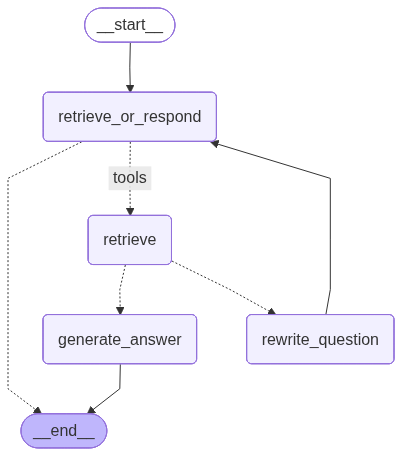

In [47]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))